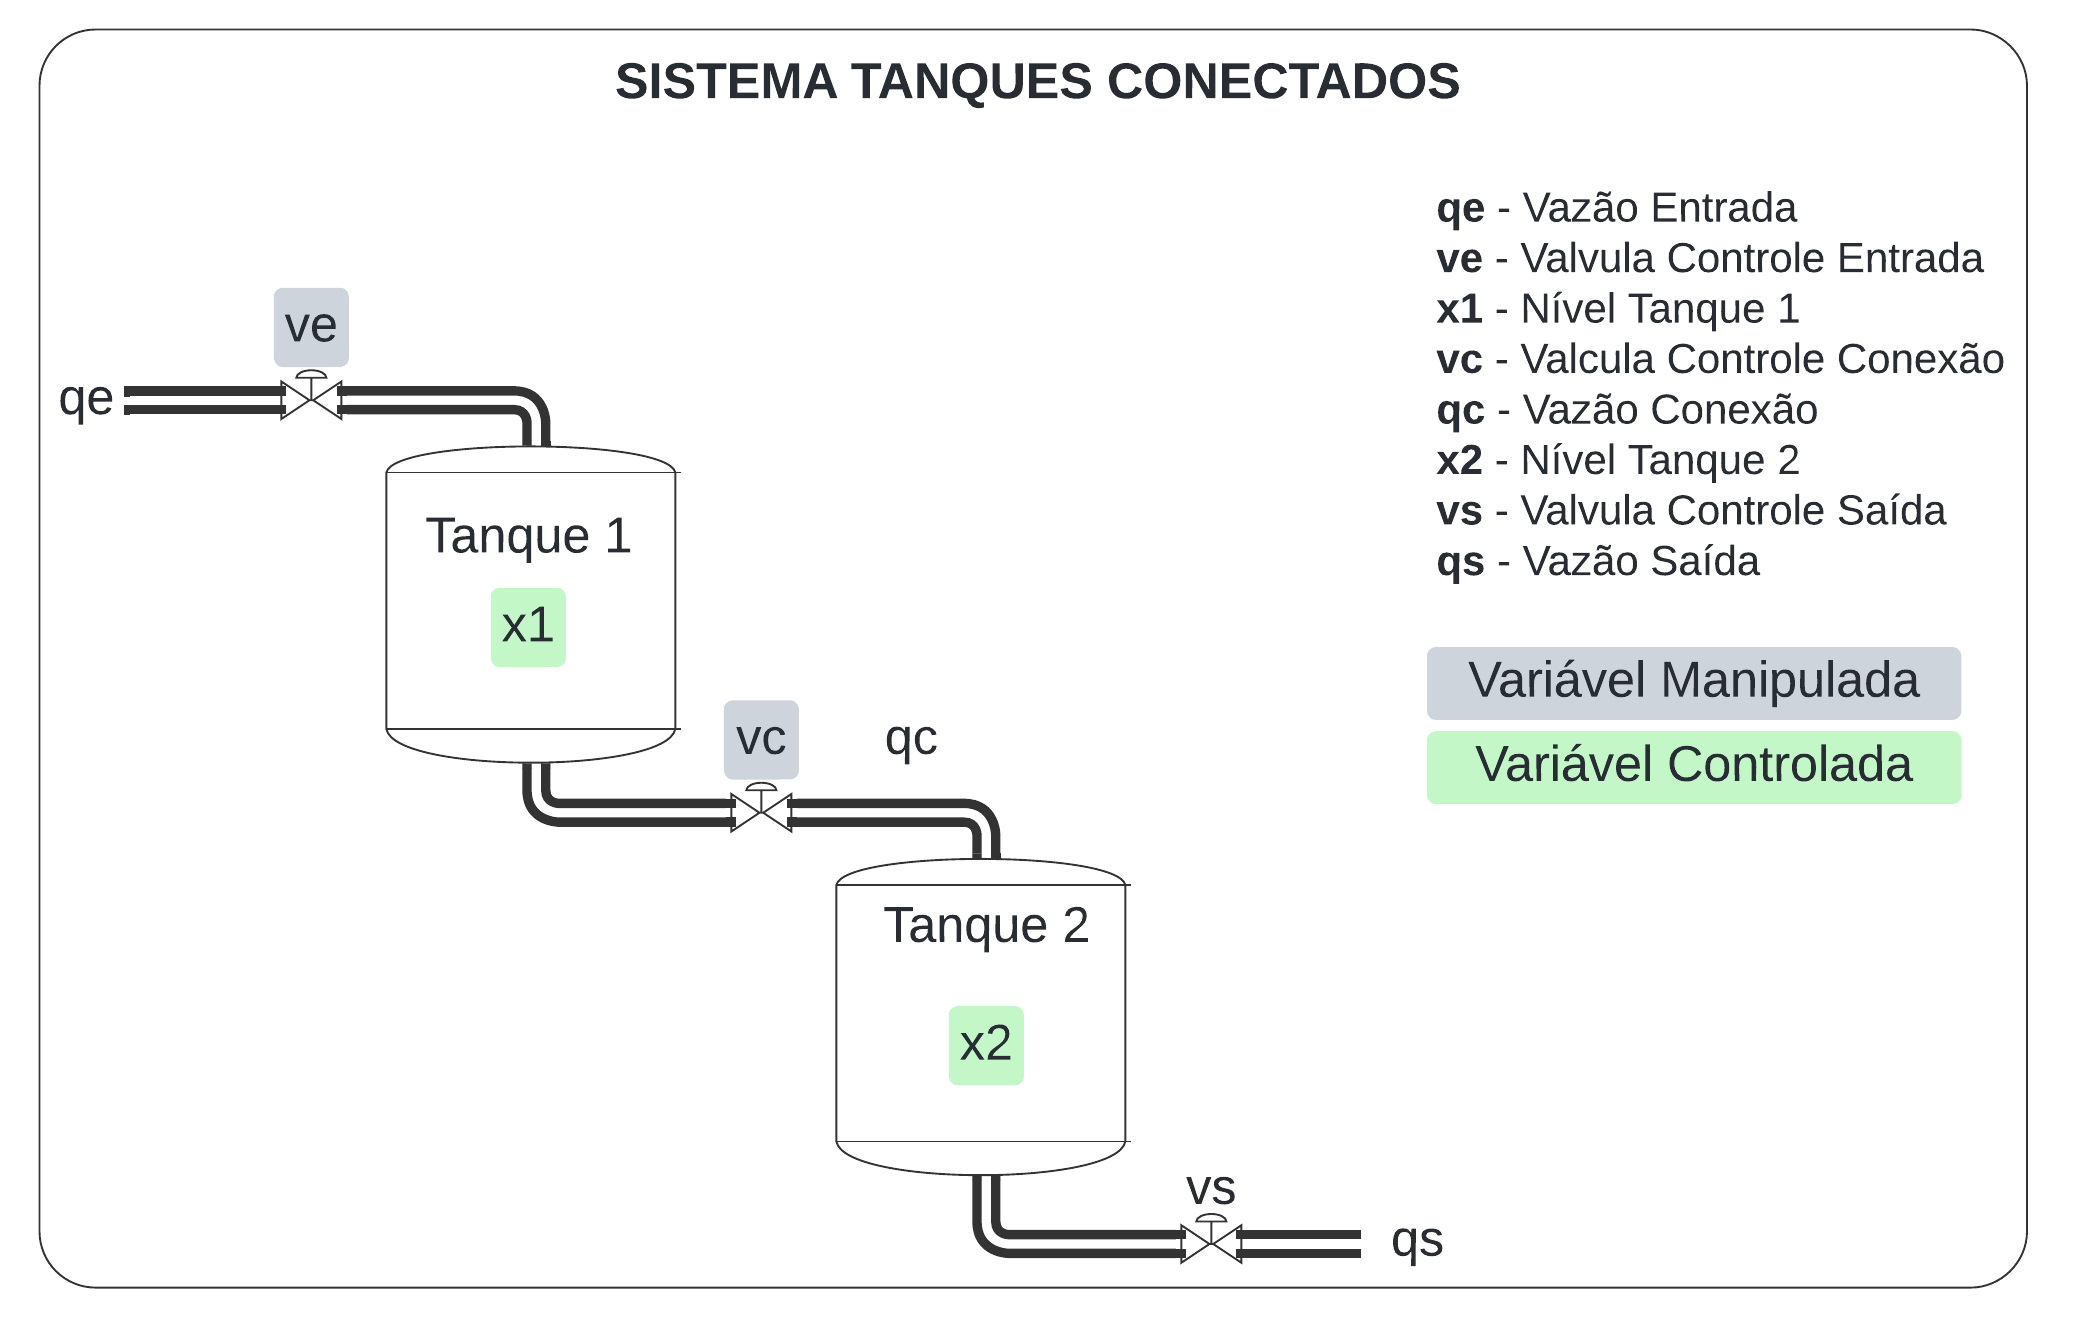

In [1]:
# docker run -d -t -i --privileged --gpus=all -p 127.0.0.1:9000:8080 -v /home/rlmariz/colab:/content --name colab-runtime us-docker.pkg.dev/colab-images/public/runtime
%cd /content/drive/MyDrive/Colab Notebooks/Mestrado/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Mestrado/'
/content


In [2]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)

import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from keras import layers
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, Lambda, SimpleRNN
from keras.models import Model, Sequential
from scipy.integrate import odeint, RK45
from keras.utils import plot_model
import timeit
from functools import partial
from matplotlib import patches
tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(SEED)
   tf.random.set_seed(SEED)
   np.random.seed(SEED)
   random.seed(SEED)

reset_random_seeds()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
def plotCorrrelation(df):
  # Pearson
  pearson = df.corr(method='pearson')
  mask_pearson = np.triu(np.ones_like(pearson, dtype=bool))
  # Spearman
  spearman = df.corr(method='spearman')
  mask_spearman = np.triu(np.ones_like(spearman, dtype=bool))

  #Print heatmap
  sns.set_theme(style='darkgrid')
  fig, ax = plt.subplots(1,2,figsize=(26,10))
  sns.heatmap(data=pearson, annot=True, mask=mask_pearson, ax=ax[0])
  ax[0].set_title("Pearson")
  sns.heatmap(data=spearman, annot=True, mask=mask_spearman, ax=ax[1])
  ax[1].set_title("Spearman")
  fig.suptitle('Map Variables')
  fig.show()

In [4]:
def plotHistory(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # MAPE
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # MAE
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

In [5]:
def plotting(history):
    plt.figure(figsize=(16, 4))
    plt.semilogy(history.history['loss'], color = "red")
    plt.semilogy(history.history['val_loss'], color = "blue")
    red_patch = patches.Patch(color='red', label='Training')
    blue_patch = patches.Patch(color='blue', label='Validation')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')

In [6]:
# Parametros Globais
np.random.seed(56)

Processo que representa um o nível de um tanque com um registro

In [7]:
import math

# Process Const
area = 4
max_level = 12
valve_k = 1

def tank_xdot(x, qe, valve=100):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, t=0.2):
  #call 1
  xd, qs = tank_xdot(x0, qe, valve);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  return x, qs;

Geração de Dados de Treinamento

In [8]:
num_data = 10000

columns = ["qe","qc", "vc","qs","x12","diff12","x11","diff11","x1","x22","diff22","x21","diff21","x2"]
data = np.zeros((0,len(columns)))

q_range = np.arange(0, 4.001, 0.01)
qe = np.random.choice(q_range, num_data)
#qc = np.random.choice(q_range, num_data)
vc = np.random.choice(np.arange(0, 101, 1), num_data)
vs = np.random.choice(np.arange(0, 101, 1), num_data)
#qs = np.random.choice(q_range, num_data)

#for l in np.arange(0, 13, 1):
for l in [6]:

  x1 = [l, l];
  x2 = [l, l];
  x = [l, l];
  diff1 = [0, 0];
  diff2 = [0, 0];

  for t in range(num_data):

      if t > 1:
        x2[0] = x1[0];
        x2[1] = x1[1];

      if t > 0:
        x1[0] = x[0];
        x1[1] = x[1];

      x[0], qc = tank_rk(x[0], qe[t]);
      #x[0], qc = tank_rk(x[0], qe[t]);

      x[1], qs = tank_rk(x[1], qc);

      if t > 1:
        diff2[0] = x2[0] - x1[0];
        diff2[1] = x2[1] - x1[1];

      if t > 0:
        diff1[0] = x1[0] - x[0];
        diff1[1] = x1[1] - x[1];

      new = np.hstack((qe[t], qc, vc[t], qs, x2[0], diff2[0], x1[0], diff1[0], x[0], x2[1], diff2[1], x1[1], diff1[1], x[1]))
      data = np.vstack((data, new))

data=pd.DataFrame(data = data, columns = columns)
data

,qe,qc,vc,qs,x12,diff12,x11,diff11,x1,x22,diff22,x21,diff21,x2
0,3.41,2.459224,63.0,2.449589,6.000000,0.000000,6.000000,0.000000,6.047782,6.000000,0.000000,6.000000,0.000000,6.000484
1,3.99,2.474658,3.0,2.449843,6.000000,0.000000,6.047782,-0.076152,6.123933,6.000000,0.000000,6.000484,-0.001247,6.001731
2,1.92,2.469077,87.0,2.450038,6.047782,-0.076152,6.123933,0.027593,6.096340,6.000484,-0.001247,6.001731,-0.000957,6.002688
3,2.35,2.467877,32.0,2.450219,6.123933,0.027593,6.096340,0.005924,6.090416,6.001731,-0.000957,6.002688,-0.000887,6.003576
4,1.22,2.455267,100.0,2.450271,6.096340,0.005924,6.090416,0.062078,6.028338,6.002688,-0.000887,6.003576,-0.000251,6.003827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.10,2.037219,64.0,1.966595,4.237478,0.090374,4.147104,-0.003158,4.150262,3.860381,-0.003560,3.863941,-0.003554,3.867495
9996,1.09,2.025633,50.0,1.967340,4.147104,-0.003158,4.150262,0.047071,4.103191,3.863941,-0.003554,3.867495,-0.002933,3.870428
9997,3.48,2.043395,43.0,1.968301,4.150262,0.047071,4.103191,-0.072273,4.175464,3.867495,-0.002933,3.870428,-0.003779,3.874207
9998,2.19,2.045177,69.0,1.969271,4.103191,-0.072273,4.175464,-0.007286,4.182749,3.870428,-0.003779,3.874207,-0.003820,3.878027


In [9]:
data.to_csv('data2.csv', index=False)

In [10]:
data.describe()

,qe,qc,vc,qs,x12,diff12,x11,diff11,x1,x22,diff22,x21,diff21,x2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.994962,1.998387,49.800200,2.002597,4.003510,0.000187,4.003328,0.000177,4.003155,4.017403,0.000212,4.017191,0.000212,4.016979
std,1.168179,0.098008,29.037913,0.081142,0.393698,0.058233,0.393196,0.058241,0.392697,0.335438,0.003479,0.334855,0.003479,0.334270
min,0.000000,1.658775,0.000000,1.805001,2.751537,-0.113400,2.751537,-0.113400,2.751537,3.258028,-0.010420,3.258028,-0.010420,3.258028
25%,0.970000,1.935545,25.000000,1.953571,3.746336,-0.050715,3.746336,-0.050724,3.746336,3.816440,-0.002158,3.816440,-0.002160,3.816440
50%,1.975000,2.003026,50.000000,2.004835,4.012112,0.001130,4.012112,0.001130,4.012112,4.019466,0.000135,4.019436,0.000135,4.019363
75%,3.020000,2.061397,75.000000,2.043481,4.249439,0.050753,4.249360,0.050753,4.249360,4.175891,0.002459,4.175830,0.002459,4.175815
max,4.000000,2.474658,100.000000,2.450271,6.123933,0.115955,6.123933,0.115955,6.123933,6.003827,0.010843,6.003827,0.010843,6.003827


In [11]:
df = data.drop(data.index[:2])
df

,qe,qc,vc,qs,x12,diff12,x11,diff11,x1,x22,diff22,x21,diff21,x2
2,1.92,2.469077,87.0,2.450038,6.047782,-0.076152,6.123933,0.027593,6.096340,6.000484,-0.001247,6.001731,-0.000957,6.002688
3,2.35,2.467877,32.0,2.450219,6.123933,0.027593,6.096340,0.005924,6.090416,6.001731,-0.000957,6.002688,-0.000887,6.003576
4,1.22,2.455267,100.0,2.450271,6.096340,0.005924,6.090416,0.062078,6.028338,6.002688,-0.000887,6.003576,-0.000251,6.003827
5,1.42,2.444757,78.0,2.450215,6.090416,0.062078,6.028338,0.051500,5.976838,6.003576,-0.000251,6.003827,0.000274,6.003552
6,2.33,2.443589,3.0,2.450147,6.028338,0.051500,5.976838,0.005709,5.971129,6.003827,0.000274,6.003552,0.000330,6.003223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.10,2.037219,64.0,1.966595,4.237478,0.090374,4.147104,-0.003158,4.150262,3.860381,-0.003560,3.863941,-0.003554,3.867495
9996,1.09,2.025633,50.0,1.967340,4.147104,-0.003158,4.150262,0.047071,4.103191,3.863941,-0.003554,3.867495,-0.002933,3.870428
9997,3.48,2.043395,43.0,1.968301,4.150262,0.047071,4.103191,-0.072273,4.175464,3.867495,-0.002933,3.870428,-0.003779,3.874207
9998,2.19,2.045177,69.0,1.969271,4.103191,-0.072273,4.175464,-0.007286,4.182749,3.870428,-0.003779,3.874207,-0.003820,3.878027


Processamento dos Dados

In [12]:
df = df.dropna()
df.std()

qe         1.168040
qc         0.097793
vc        29.036745
qs         0.080903
x12        0.392723
diff12     0.058239
x11        0.392195
diff11     0.058241
x1         0.391630
x22        0.334298
diff22     0.003479
x21        0.333711
diff21     0.003479
x2         0.333123
dtype: float64

In [13]:
#X_train=df[["qe", "qc", "qs", "x1", "diff12", "x2", "diff22"]]
X_train=df[["qe", "qc", "qs", "x1", "diff12", "x2", "diff22"]]
#X_train=df[["qe", "qc", "qs", "x1", "x2", "diff12", "diff22"]]
#X_train=df[["qe", "qc", "qs", "x1", "x2"]].values
y_train=df[["diff11","diff21"]]

#X_train=df[["qe", "qc", "x1", "diff12"]]
#y_train=df[["diff11"]]

#X_train=df[["qc", "qs", "x2", "diff22"]].values
#y_train=df[["diff21"]].values

In [14]:
X_train.describe()

,qe,qc,qs,x1,diff12,x2,diff22
count,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,1.994621,1.998293,2.002508,4.002739,0.000187,4.016582,0.000212
std,1.168040,0.097793,0.080903,0.391630,0.058239,0.333123,0.003479
min,0.000000,1.658775,1.805001,2.751537,-0.113400,3.258028,-0.010420
25%,0.970000,1.935544,1.953567,3.746331,-0.050718,3.816426,-0.002159
50%,1.970000,2.002988,2.004814,4.011959,0.001149,4.019279,0.000136
75%,3.020000,2.061358,2.043448,4.249198,0.050756,4.175680,0.002460
max,4.000000,2.469077,2.450271,6.096340,0.115955,6.003827,0.010843


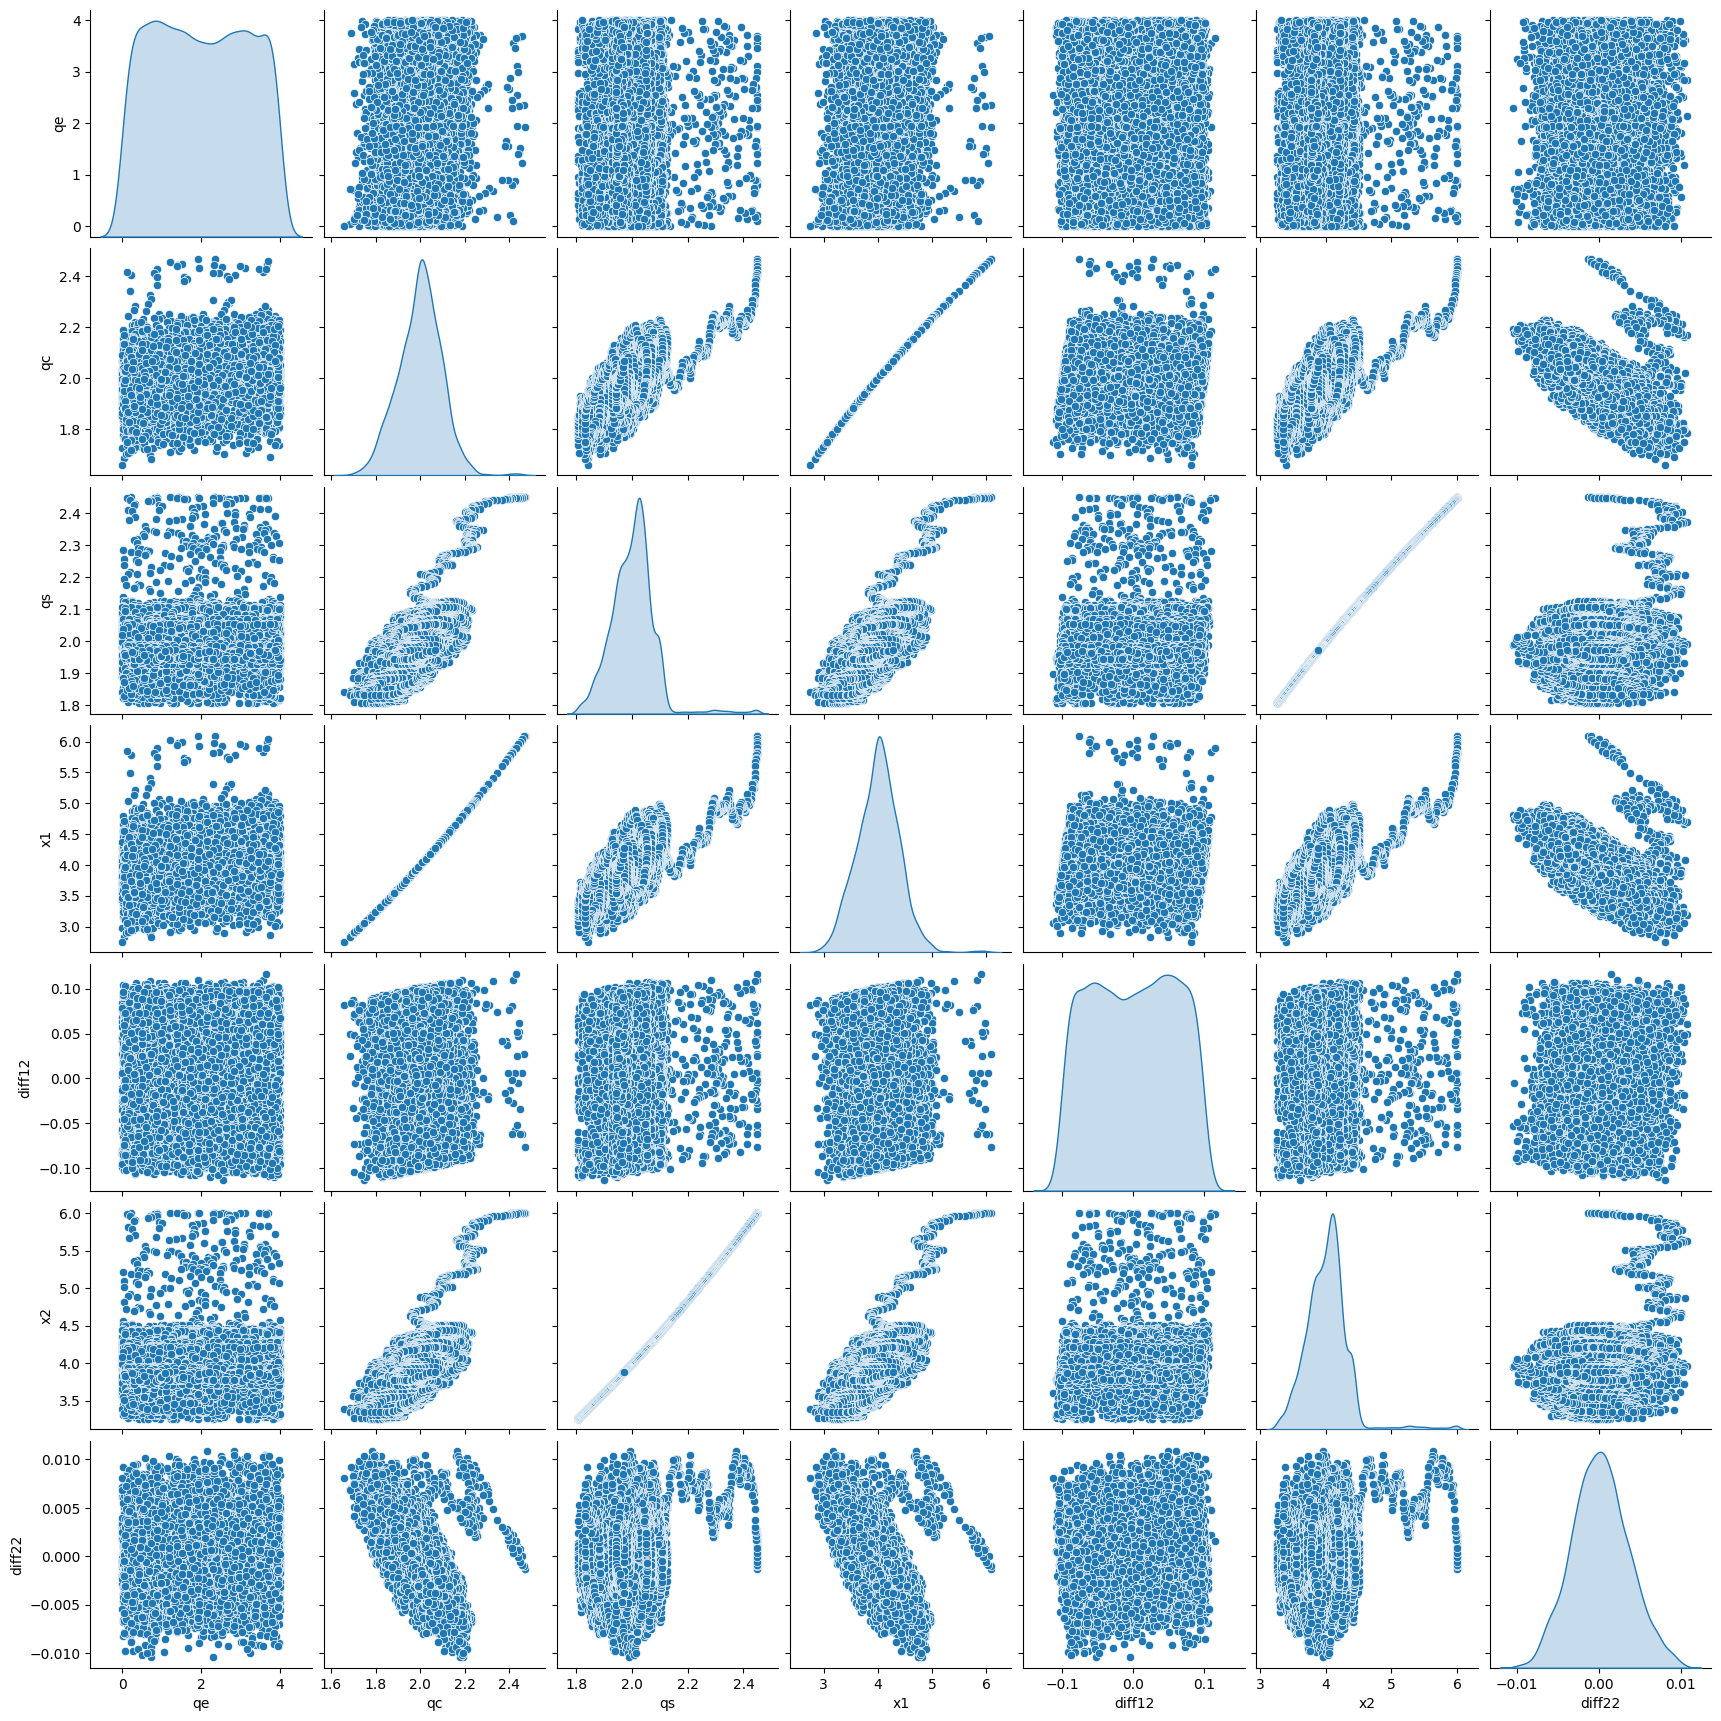

In [15]:
sns.pairplot(X_train, diag_kind="kde")
#sns.pairplot(X_train[["qe", "qc", "x1", "diff12"]], diag_kind="scatter")
#X_train[["qe", "qc", "x1", "diff12"]

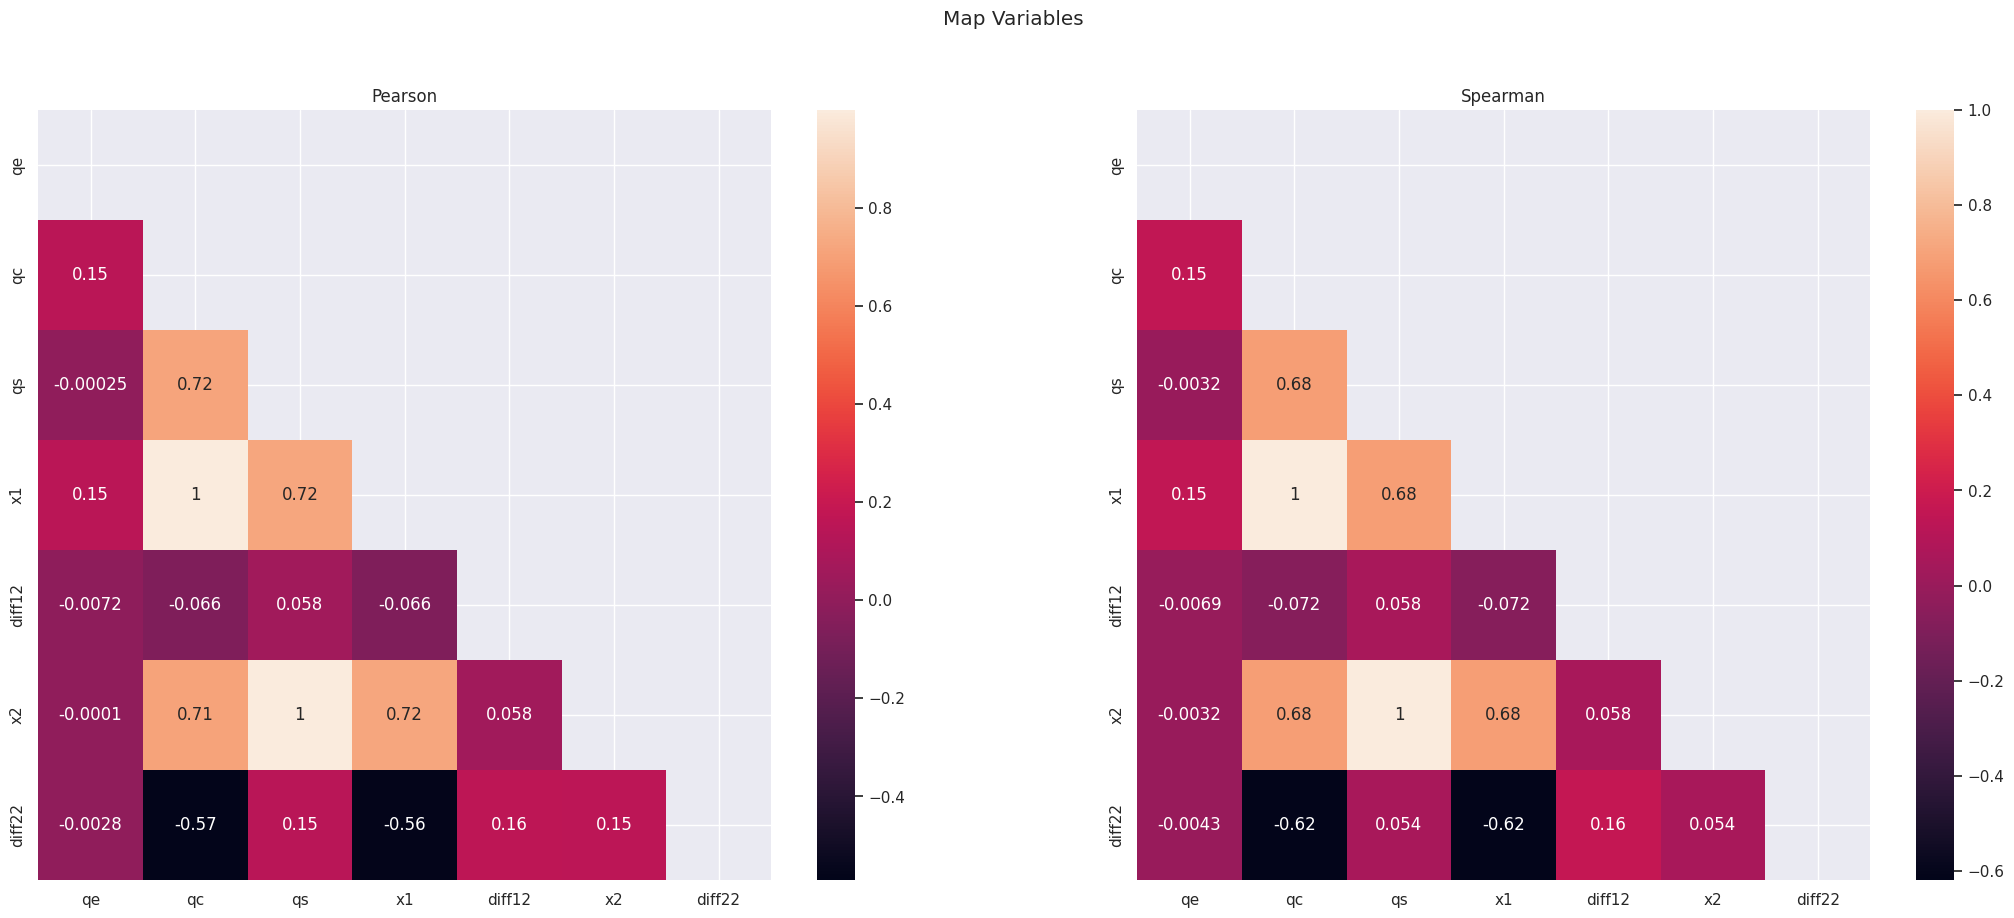

In [16]:
plotCorrrelation(X_train)

In [17]:
X_train=X_train.values
y_train=y_train.values

In [18]:
from sklearn.preprocessing import StandardScaler
scaler_x_train = StandardScaler()
x_train = scaler_x_train.fit_transform(X_train)
x_train

array([[-0.0638888 ,  4.81431304,  5.53196922, ..., -1.3108374 ,
         5.96238053, -0.41951725],
       [ 0.3042678 ,  4.80204321,  5.5342077 , ...,  0.47061046,
         5.96504451, -0.33606167],
       [-0.66321351,  4.67309508,  5.53484108, ...,  0.09851666,
         5.96579835, -0.31611188],
       ...,
       [ 1.2717491 ,  0.46122117, -0.42283951, ...,  0.80507154,
        -0.42741697, -0.90420945],
       [ 0.16727929,  0.47944233, -0.41084899, ..., -1.24422668,
        -0.41595058, -1.14723937],
       [ 1.60565858,  0.70495361, -0.39557869, ..., -0.128307  ,
        -0.40133964, -1.15897823]])

In [ ]:
#from sklearn.decomposition import PCA
# Cria o classificador PCA
#pca = PCA(n_components=1)
#x_train = pca.fit_transform(x_train)
#x_train
#y_train = pca.fit_transform(y_train)
#y_train

In [ ]:
#scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train)
#y_train

Modelo de Rede Neural

In [ ]:
#model = Sequential()
#model.add(Dense(32, activation='relu', input_dim=x_train.shape[1]))
#model.add(Dense(1, activation='relu', input_dim=x_train.shape[1]))
#model.add(Lambda(lambda x: x, input_dim=x_train.shape[1]))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.5)));
#model.add(Dense(128, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(2, kernel_initializer=tf.initializers.zeros))
#model.add(Dense(1, kernel_initializer=tf.initializers.zeros))

model = Sequential([
    SimpleRNN(50, input_shape=(10, 7), activation='relu', return_sequences=False),  # Camada RNN com 50 unidades e ativação ReLU
    Dense(2)  # Camada de saída com 2 neurônios
])

In [22]:
X = np.random.randn(100, 10, 7)  # Sequência de entrada com 100 amostras, cada amostra com 10 timesteps e 7 features
Y = np.random.randn(100, 2)  # Sequência de saída correspondente com 2 saídas
X

array([[[-0.10885321,  0.25225169, -0.44174237, ...,  1.28623705,
          0.15200171, -0.36810943],
        [ 0.69670973, -1.24296067, -0.25108019, ..., -1.38459261,
         -0.69577228,  0.16329227],
        [ 1.82784713,  0.17309107,  0.54441732, ..., -1.44685987,
          0.73696897,  1.16042003],
        ...,
        [-0.21570379,  0.14090973, -1.14605196, ..., -0.3769344 ,
          0.95277576, -0.13864825],
        [ 0.98014921, -0.42349181, -0.07463277, ...,  0.86462404,
          0.95428344, -0.97245283],
        [ 0.29985511, -0.13045369, -0.00766777, ..., -0.02621771,
          1.89354711, -0.23654616]],

       [[-1.48250943, -0.55480914, -1.58074759, ..., -0.84656783,
          0.93766924,  0.88523999],
        [ 0.11182069, -0.10273622, -0.67351441, ..., -1.10566143,
          0.99909213, -0.72260372],
        [-1.87972259,  0.83926408, -1.34076313, ..., -1.17245408,
          0.32158464,  0.55812711],
        ...,
        [-0.23139798, -0.41125344,  0.2389056 , ...,  

In [ ]:
lr=0.001
optimizer = tf.optimizers.Adam(learning_rate=lr)
loss=tf.losses.MeanSquaredError()
metrics=[tf.metrics.MeanSquaredError()]
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
#model.compile(loss='mape', metrics=['mae'], optimizer=optimizer)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora a métrica de validação
    patience=20,  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os pesos do modelo à melhor época
)

In [ ]:
num_epochs=100
num_batch_size=10
#patience=150
history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = num_batch_size,
            epochs = num_epochs,
            verbose = 1,
            callbacks=[early_stopping],
            validation_split = 0.2
          )
history

Epoch 1/100
800/800 [==============================] - 6s 6ms/step - loss: 3.8110e-04 - mean_squared_error: 3.8110e-04 - val_loss: 1.4657e-04 - val_mean_squared_error: 1.4657e-04
Epoch 2/100
800/800 [==============================] - 5s 7ms/step - loss: 5.9993e-05 - mean_squared_error: 5.9993e-05 - val_loss: 1.2755e-05 - val_mean_squared_error: 1.2755e-05
Epoch 3/100
800/800 [==============================] - 5s 6ms/step - loss: 8.7043e-06 - mean_squared_error: 8.7043e-06 - val_loss: 7.1167e-06 - val_mean_squared_error: 7.1167e-06
Epoch 4/100
800/800 [==============================] - 6s 7ms/step - loss: 8.0999e-06 - mean_squared_error: 8.0999e-06 - val_loss: 7.5602e-06 - val_mean_squared_error: 7.5602e-06
Epoch 5/100
800/800 [==============================] - 4s 5ms/step - loss: 8.1841e-06 - mean_squared_error: 8.1841e-06 - val_loss: 7.5947e-06 - val_mean_squared_error: 7.5947e-06
Epoch 6/100
800/800 [==============================] - 4s 6ms/step - loss: 8.0003e-06 - mean_squared_erro

In [ ]:
#model.summary()

In [ ]:
#model_name="best2"

#model.save(f'{model_name}-model.h5')

#model_json = model.to_json()
#with open(f'{model_name}-model.json', 'w') as json_file:
    #json_file.write(model_json)

#model.save_weights(f'{model_name}-weights.h5')

In [ ]:
#plotHistory(history, 'History')

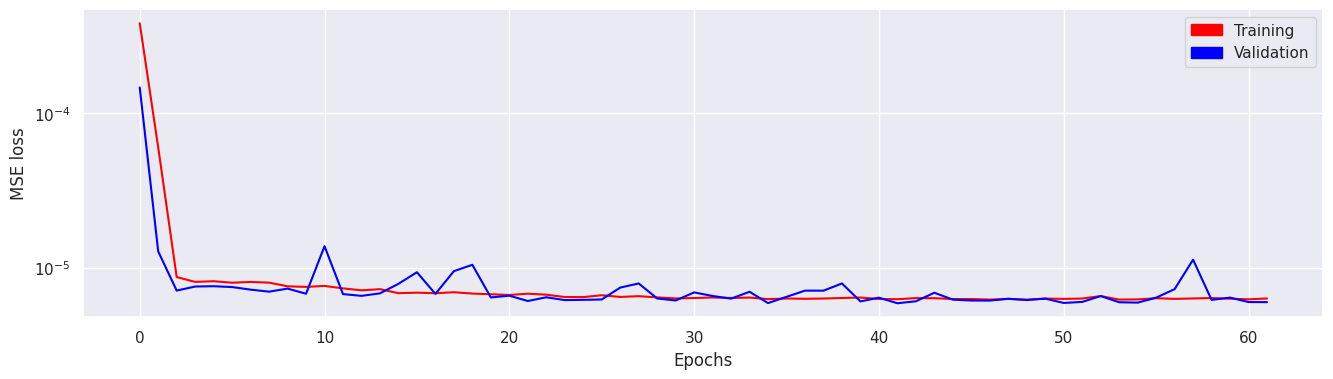

In [ ]:
plotting(history)

Simulação Degrau Unitário para verificar se a rede neural tem comportamento semelhante ao processo.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

sim_degree_columns = ["qe", "qc", "qs", "x1", "x2", "NN_x1", "NN_x2"]
sim_degree = np.zeros((1,len(sim_degree_columns)))

pred_nn_columns = ["qe", "qc", "qs", "NN_x[0]", "NN_x[1]", "diff2[0]", "diff2[1]", "NN_pred[0]", "NN_pred[1]"]
pred_nn = np.zeros((1,len(pred_nn_columns)))

num_sim = 20
diff1 = [0, 0];
diff2 = [0, 0];
NN_pred = [0, 0];
x = [0, 0];
NN_x2 = [0, 0];
NN_x1 = [0, 0];
NN_x =  [0, 0];
qe = 1.0;

for t in range(num_sim):

    if t > 1:
      NN_x2[0] = NN_x1[0];
      NN_x2[1] = NN_x1[1];

    if t > 0:
      NN_x1[0] = NN_x[0];
      NN_x1[1] = NN_x[1];

    x[0], qc = tank_rk(x[0] , qe)

    x[1], qs = tank_rk(x[1] , qc)

    if t > 2:
      #NN_in = np.array([[qe, qc, NN_x[0], diff2[0]]])
      #NN_in = np.array([[qc, qs, NN_x[1], diff2[1]]])
      NN_in = np.array([[qe, qc, qs, NN_x[0], NN_x[1], diff2[0], diff2[1]]])
      #NN_in = np.array([[qe, qc, qs, NN_x[0], NN_x[1]]])
      #NN_in = np.array([[qe, qc, qs, NN_x[0], diff2[0], NN_x[1], diff2[1]]])

      NN_in = scaler_x_train.transform(NN_in)
      #NN_in = np.array(pca.transform([[qe, qc, qs, NN_x[0], NN_x[1], diff2[0], diff2[1]]]))

      NN_pred = model.predict(NN_in, verbose = None)[0];
      #NN_pred = [NN_pred, NN_pred]
      #NN_pred = model.predict(NN_in, verbose = None)[0];
      #NN_pred = pca.inverse_transform(NN_pred)[0];

      #NN_pred = model.predict(NN_in, verbose = None)[0];
      #NN_pred = model.predict(NN_in, verbose = None)[0];
      #NN_pred = scaler_y.inverse_transform(NN_pred)[0][0];
      #NN_pred = scaler_y.inverse_transform(NN_pred)[0][0];

      NN_x[0] -= NN_pred[0]
      NN_x[1] -= NN_pred[1]
      #NN_x[0] -= NN_pred
      #NN_x[1] -= NN_pred
      #print(NN_pred)
    else:
      NN_x[0] = x[0]
      NN_x[1] = x[1]

    #print(NN_x)

    if t > 1:
      diff2[0] = NN_x2[0] - NN_x1[0];
      diff2[1] = NN_x2[1] - NN_x1[1];

    if t > 0:
      diff1[0] = NN_x1[0] - NN_x[0];
      diff1[1] = NN_x1[1] - NN_x[1];

    sim_degree = np.vstack((sim_degree, (qe, qc, qs, x[0], x[1], NN_x[0], NN_x[1])))
    pred_nn = np.vstack((pred_nn, (qe, qc, qs, NN_x[0], NN_x[1], diff2[0], diff2[1], NN_pred[0], NN_pred[1])))
sim_degree = pd.DataFrame(data = sim_degree, columns = sim_degree_columns)
pred_nn = pd.DataFrame(data = pred_nn, columns = pred_nn_columns)
sim_degree

,qe,qc,qs,x1,x2,NN_x1,NN_x2
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.206751,0.086223,0.043224,0.007453,0.043224,0.007453
2,1.0,0.284217,0.127430,0.080791,0.016218,0.080791,0.016218
3,1.0,0.339327,0.161037,0.115143,0.025919,0.115143,0.025919
4,1.0,0.383459,0.190470,0.147038,0.036268,0.144484,0.026162
5,1.0,0.420614,0.217011,0.176912,0.047085,0.171612,0.026387
6,1.0,0.452838,0.241359,0.205059,0.058247,0.206724,0.026675
7,1.0,0.481346,0.263952,0.231691,0.069664,0.240742,0.026954
8,1.0,0.506928,0.285090,0.256973,0.081271,0.273657,0.027224
9,1.0,0.530133,0.304989,0.281038,0.093013,0.305601,0.027487


In [ ]:
pred_nn

,qe,qc,qs,NN_x[0],NN_x[1],diff2[0],diff2[1],NN_pred[0],NN_pred[1]
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.206751,0.086223,0.043224,0.007453,0.000000,0.000000,0.000000,0.000000
2,1.0,0.284217,0.127430,0.080791,0.016218,0.000000,0.000000,0.000000,0.000000
3,1.0,0.339327,0.161037,0.115143,0.025919,-0.037567,-0.008765,0.000000,0.000000
4,1.0,0.383459,0.190470,0.144484,0.026162,-0.034352,-0.009701,-0.029341,-0.000243
5,1.0,0.420614,0.217011,0.171612,0.026387,-0.029341,-0.000243,-0.027128,-0.000225
6,1.0,0.452838,0.241359,0.206724,0.026675,-0.027128,-0.000225,-0.035112,-0.000288
7,1.0,0.481346,0.263952,0.240742,0.026954,-0.035112,-0.000288,-0.034018,-0.000279
8,1.0,0.506928,0.285090,0.273657,0.027224,-0.034018,-0.000279,-0.032914,-0.000270
9,1.0,0.530133,0.304989,0.305601,0.027487,-0.032914,-0.000270,-0.031944,-0.000263


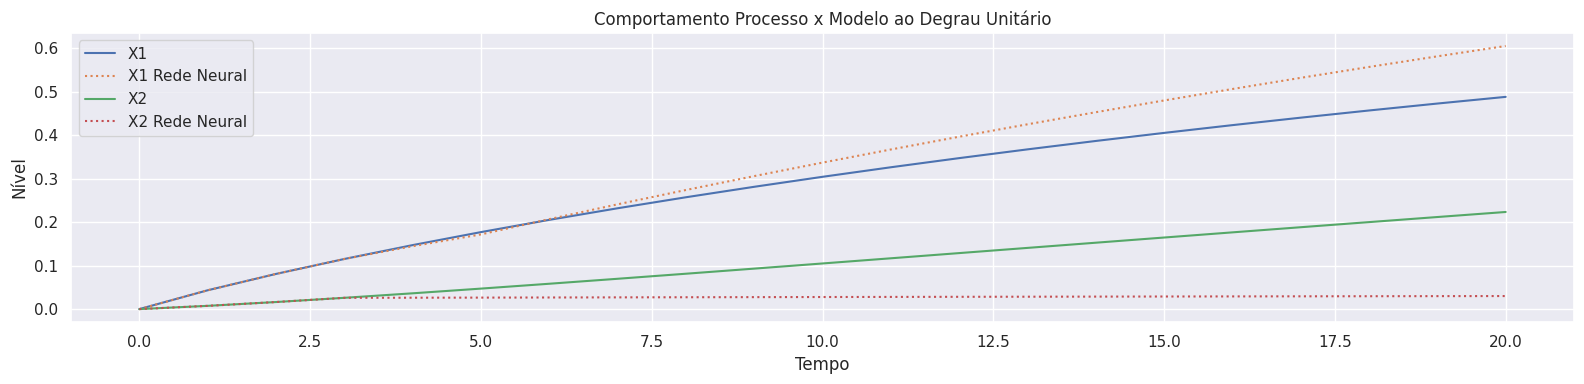

In [ ]:
# Criando o gráfico
plt.figure(figsize=(16, 4))  # Define o tamanho do gráfico

# Plot da variável de controle
#plt.plot(thisishistory['x'], label='Variável de Controle', marker='o')
plt.plot(sim_degree["x1"], label='X1')
plt.plot(sim_degree["NN_x1"], label='X1 Rede Neural', linestyle=':')

plt.plot(sim_degree["x2"], label='X2')
plt.plot(sim_degree["NN_x2"], label='X2 Rede Neural', linestyle=':')


# Adicionando rótulos aos eixos e título
plt.xlabel('Tempo')
plt.ylabel('Nível')
plt.title('Comportamento Processo x Modelo ao Degrau Unitário')

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.tight_layout()  # Ajusta o layout
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Dados de exemplo: Sequência de entrada e sequência de saída
X = np.random.randn(100, 10, 1)  # Sequência de entrada com 100 amostras, cada amostra com 10 timesteps e 1 feature
Y = np.random.randn(100, 1)  # Sequência de saída correspondente

# Construindo o modelo RNN
model = Sequential([
    SimpleRNN(50, input_shape=(10, 1), activation='relu', return_sequences=True),  # Camada RNN com 50 unidades e ativação ReLU
    Dense(1)  # Camada de saída com 1 neurônio
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mse')  # Usando o otimizador Adam e a perda de erro quadrático médio (MSE)

# Treinando o modelo
model.fit(X, Y, epochs=10, batch_size=32, validation_split=0.2)  # Treinando por 10 épocas com batch size de 32 e validação de 20%


Epoch 1/10
3/3 [==============================] - 2s 242ms/step - loss: 0.9308 - val_loss: 1.5159
Epoch 2/10
3/3 [==============================] - 0s 20ms/step - loss: 0.8728 - val_loss: 1.4547
Epoch 3/10
3/3 [==============================] - 0s 19ms/step - loss: 0.8374 - val_loss: 1.4160
Epoch 4/10
3/3 [==============================] - 0s 19ms/step - loss: 0.8205 - val_loss: 1.3912
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 0.8106 - val_loss: 1.3757
Epoch 6/10
3/3 [==============================] - 0s 18ms/step - loss: 0.8054 - val_loss: 1.3660
Epoch 7/10
3/3 [==============================] - 0s 22ms/step - loss: 0.8002 - val_loss: 1.3611
Epoch 8/10
3/3 [==============================] - 0s 20ms/step - loss: 0.7943 - val_loss: 1.3600
Epoch 9/10
3/3 [==============================] - 0s 23ms/step - loss: 0.7890 - val_loss: 1.3588
Epoch 10/10
3/3 [==============================] - 0s 20ms/step - loss: 0.7832 - val_loss: 1.3581


In [ ]:
!pip install nengolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: nengo
    Found existing installation: nengo 4.0.0
    Uninstalling nengo-4.0.0:
      Successfully uninstalled nengo-4.0.0


In [ ]:
import math
import numpy as np
import matplotlib.pylab as plt
from pyneurgen.neuralnet import NeuralNet
from pyneurgen.recurrent import NARXRecurrent


def plot_results(x, y, y_true):
    plt.subplot(3, 1, 1)
    plt.plot([i[1] for i in population])
    plt.title("Population")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(x, y, 'bo', label='targets')
    plt.plot(x, y_true, 'ro', label='actuals')
    plt.grid(True)
    plt.legend(loc='lower left', numpoints=1)
    plt.title("Test Target Points vs Actual Points")

    plt.subplot(3, 1, 3)
    plt.plot(range(1, len(net.accum_mse) + 1, 1), net.accum_mse)
    plt.xlabel('epochs')
    plt.ylabel('mean squared error')
    plt.grid(True)
    plt.title("Mean Squared Error by Epoch")
    plt.show()

def generate_data():
    # all samples are drawn from this population
    pop_len = 200
    factor = 1.0 / float(pop_len)
    population = [[i, math.sin(float(i) * factor * 10.0)] for i in range(pop_len)]
    population_shuffle = population[:]

    all_inputs = []
    all_targets = []

    np.random.shuffle(population_shuffle)
    for position, target in population_shuffle:
        all_inputs.append([position * factor])
        all_targets.append([target])
        # print(all_inputs[-1], all_targets[-1])
    return population, all_inputs, all_targets

# generate data
population, all_inputs, all_targets =  generate_data()

# NARXRecurrent
input_nodes, hidden_nodes, output_nodes = 1, 10, 1
output_order, incoming_weight_from_output = 3, .6
input_order, incoming_weight_from_input = 2, .4

# init neural network
net = NeuralNet()
net.init_layers(input_nodes, [hidden_nodes], output_nodes,
                NARXRecurrent(output_order, incoming_weight_from_output,
                              input_order, incoming_weight_from_input))
net.randomize_network()
net.set_halt_on_extremes(True)

# set constrains and rates
net.set_random_constraint(.5)
net.set_learnrate(.1)

# set inputs and outputs
net.set_all_inputs(all_inputs)
net.set_all_targets(all_targets)

# set lengths
length = len(all_inputs)
learn_end_point = int(length * .8)

# set ranges
net.set_learn_range(0, learn_end_point)
net.set_test_range(learn_end_point + 1, length - 1)

# add activation to layer 1
net.layers[1].set_activation_type('tanh')

# fit data to model
net.learn(epochs=150, show_epoch_results=True, random_testing=False)

# define mean squared error
mse = net.test()
print("Testing mse = ")
print(mse)

# define data
x = [item[0][0] * 200.0 for item in net.get_test_data()]
y = [item[0][0] for item in net.test_targets_activations]
y_true = [item[1][0] for item in net.test_targets_activations]

# plot results
plot_results(x, y, y_true)


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (neuralnet.py, line 613)

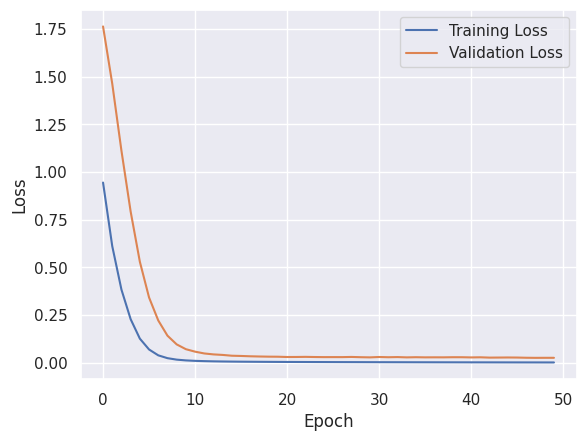

1/1 [==============================] - 0s 487ms/step


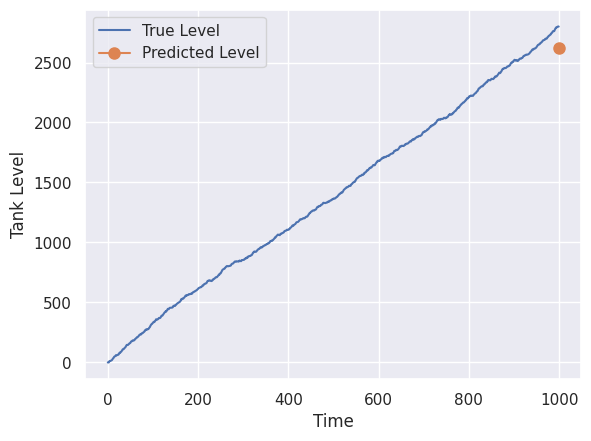

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Gerando dados simulados de um tanque
def generate_tank_data(length=1000, n_features=3):
    # Parâmetros do tanque
    inflow_rate = np.random.uniform(1, 10, size=length)
    outflow_rate = np.random.uniform(0.5, 5, size=length)
    tank_level = np.zeros(length)

    # Simulação do tanque
    for i in range(1, length):
        tank_level[i] = tank_level[i-1] + inflow_rate[i] - outflow_rate[i]

    # Concatenando as séries temporais
    data = np.vstack([inflow_rate, outflow_rate, tank_level]).T
    return data

# Gerando dados de treinamento
data = generate_tank_data()
n_samples, n_features = data.shape

# Dividindo os dados em entrada (X) e saída (Y)
X = data[:-1]  # Todas as características até o penúltimo instante de tempo
Y = data[1:, -1:]  # Nível do tanque no próximo instante de tempo

# Normalizando os dados
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
Y_mean = Y.mean()
Y_std = Y.std()
X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std

# Reformatando os dados para entrada na RNN
X = X.reshape(-1, 1, n_features)

# Construindo o modelo RNN
model = Sequential([
    SimpleRNN(32, input_shape=(1, n_features), activation='relu', return_sequences=False),
    Dense(1)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mse')

# Treinando o modelo
history = model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Plotando a perda durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testando o modelo
X_test = X[-1:]  # Última amostra de entrada (condição inicial para previsão)
predictions = model.predict(X_test).flatten()

# Desnormalizando as previsões
predictions = predictions * Y_std + Y_mean

# Plotando os resultados
plt.plot(data[:, -1], label='True Level')
plt.plot(np.arange(len(data)-1, len(data)), predictions, marker='o', markersize=8, label='Predicted Level')
plt.xlabel('Time')
plt.ylabel('Tank Level')
plt.legend()
plt.show()


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Gerar dados de treinamento simulados
def generate_data(length=1000):
    tank1_level = np.random.uniform(0, 10, size=length)  # Níveis do tanque 1 (entrada)
    inflow_rate = np.random.uniform(0, 5, size=length)  # Taxa de fluxo de entrada para o tanque 1
    tank2_level = np.zeros(length)  # Níveis do tanque 2 (saída)

    # Simulação do nível do tanque 2
    for i in range(1, length):
        tank2_level[i] = tank2_level[i-1] + (inflow_rate[i] - tank2_level[i-1]) * 0.1  # Simplesmente integrando o fluxo

    return np.column_stack((tank1_level, inflow_rate)), tank2_level

# Gerar dados de treinamento
X_train, y_train = generate_data()

# Normalizar os dados
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
y_mean = y_train.mean()
y_std = y_train.std()
X_train = (X_train - X_mean) / X_std
y_train = (y_train - y_mean) / y_std

# Definir a arquitetura da rede neural
model = Sequential([
    Dense(32, input_shape=(2,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo com dados de teste (opcional)
# test_loss = model.evaluate(X_test, y_test)

# Fazer previsões com o modelo treinado (usando dados de treinamento neste exemplo)
# X_test_normalized = (X_test - X_mean) / X_std
# predictions = model.predict(X_test_normalized)


Epoch 1/50
25/25 [==============================] - 2s 17ms/step - loss: 0.9820 - val_loss: 0.8400
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.9009 - val_loss: 0.8321
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.8847 - val_loss: 0.8497
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.8840 - val_loss: 0.8268
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.8813 - val_loss: 0.8306
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.8804 - val_loss: 0.8335
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.8793 - val_loss: 0.8390
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 0.8802 - val_loss: 0.8461
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 0.8792 - val_loss: 0.8271
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 0.8777 - val_loss: 0.8525
Epoch 11/50
25/25 

In [25]:
X_train

array([[ 1.1242269 , -0.33088067],
       [ 0.41128241,  1.25485535],
       [-1.45216458,  0.69363553],
       ...,
       [ 1.06194576,  0.61156712],
       [-0.36492531,  0.61387705],
       [ 0.07983166,  0.52318501]])